In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

SEEDS = [40, 41, 43, 44, 45, 46, 47, 48, 49, 50]
TEST_SPLIT_SEED = 40   # 테스트셋은 한 번만 고정

def rmse(y_true, y_pred):
    # 버전 의존 옵션 없이 직접 계산
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [4]:
CSV_PATH = "preprocessed_wildfire_20250816.csv"
TARGET   = "FIRE_SUPESN_HR"

df = pd.read_csv(CSV_PATH)
print("[STEP0] 데이터 로드:", df.shape)
display(df.head(10))

X = df.drop(columns=[TARGET])
y = df[TARGET].values


[STEP0] 데이터 로드: (3560, 19)


,DSPT_REQ_HR,FIRE_SUPESN_HR,CTPV_NM,SGG_NM,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,LFDAU_GRNDS_DSTNC,FCLT_PLC_SCLSF_NM,FND_FIRE_SE_NM,FND_IGTN_PSTN_NM,HR_UNIT_ARTMP,HR_UNIT_WSPD_INFO,WNDRCT_BRNG,HR_UNIT_HUM,golden_time_under_50min,arrival_time_diff,is_night,month_rcpt,dispatch_time_diff
0,246,1200,8,66,11,4,-1.0,1,1,1,-1.0,2.0,7,39.0,1,337.0,1,1,91.0
1,253,600,8,66,4,2,-1.0,0,0,1,5.0,2.0,3,60.0,1,291.0,1,3,38.0
2,643,1457,8,66,9,5,-1.0,1,1,1,7.0,2.0,3,49.0,1,676.0,1,3,33.0
3,578,1529,4,62,5,2,-1.0,1,1,3,0.3,10.5,7,48.0,1,636.0,0,3,58.0
4,874,14464,0,16,26,10,-1.0,2,2,4,-8.7,20.0,8,36.0,1,906.0,1,12,32.0
5,565,19818,10,150,28,8,-1.0,1,1,1,2.3,2.0,7,38.0,1,764.0,0,12,199.0
6,649,6483,0,4,5,7,-1.0,2,2,1,-2.9,20.0,3,36.0,1,690.0,1,12,41.0
7,440,6678,12,47,23,12,16.0,2,2,4,-1.2,2.0,6,89.0,1,446.0,0,1,6.0
8,313,0,7,48,8,1,-1.0,1,1,2,10.2,2.0,8,35.0,1,389.0,0,12,76.0
9,1151,5437,12,219,23,15,-1.0,2,2,1,12.9,2.0,7,26.0,1,1171.0,0,12,20.0


In [5]:
print("\n[STEP1] EDA 요약")
print("자료형 빈도:")
print(df.dtypes.value_counts(), "\n")

print("기초통계(숫자형):")
display(df.describe().T)

print("결측치 Top10:")
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(10))



[STEP1] EDA 요약
자료형 빈도:
int64      13
float64     6
Name: count, dtype: int64 

기초통계(숫자형):


,count,mean,std,min,25%,50%,75%,max
DSPT_REQ_HR,3560.0,704.108427,640.660144,0.0,361.00,581.0,878.0,16468.0
FIRE_SUPESN_HR,3560.0,6741.344382,11090.968328,0.0,1620.00,3583.5,7163.0,85323.0
CTPV_NM,3560.0,5.764607,5.573609,0.0,1.00,3.0,12.0,16.0
SGG_NM,3560.0,114.305056,67.629008,0.0,52.00,119.0,172.0,221.0
FRSTN_GRNDS_DSTNC,3560.0,16.356742,11.894886,0.0,8.00,14.0,22.0,99.0
CNTR_GRNDS_DSTNC,3560.0,8.669101,7.263789,0.0,3.00,7.0,12.0,74.0
LFDAU_GRNDS_DSTNC,3560.0,1.463202,4.562795,-1.0,-1.00,-1.0,3.0,38.0
FCLT_PLC_SCLSF_NM,3560.0,1.698034,0.605859,0.0,2.00,2.0,2.0,2.0
FND_FIRE_SE_NM,3560.0,1.698034,0.605859,0.0,2.00,2.0,2.0,2.0
FND_IGTN_PSTN_NM,3560.0,1.959831,1.098577,0.0,1.00,1.0,3.0,4.0


결측치 Top10:


DSPT_REQ_HR                0
HR_UNIT_ARTMP              0
month_rcpt                 0
is_night                   0
arrival_time_diff          0
golden_time_under_50min    0
HR_UNIT_HUM                0
WNDRCT_BRNG                0
HR_UNIT_WSPD_INFO          0
FND_IGTN_PSTN_NM           0
dtype: int64

In [6]:
print("\n[STEP2] GridSearchCV (XGBoost, 작은 탐색공간, RMSE 커스텀 스코어)")

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)  # 작을수록 좋음 → 음수

param_grid = {
    "n_estimators":     [600, 1000],
    "max_depth":        [4, 6, 8],
    "learning_rate":    [0.03, 0.05, 0.10],
    "subsample":        [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "reg_lambda":       [0.0, 1.0],
    "reg_alpha":        [0.0, 0.1],
}

base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1,
    verbose=0
)
grid.fit(X, y)

best_params = grid.best_params_
best_rmse_cv = -grid.best_score_  # 부호 반전

print("Best Params:", best_params)
print(f"Best CV RMSE: {best_rmse_cv:.4f}")



[STEP2] GridSearchCV (XGBoost, 작은 탐색공간, RMSE 커스텀 스코어)
Best Params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 600, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.9}
Best CV RMSE: 11107.2966


In [7]:
print("\n[STEP3] 10회 반복 학습 (각각 5-Fold CV), 6:2:2 분할 / Test 고정")

# Test 20% 고정
X_rem, X_test, y_rem, y_test = train_test_split(
    X, y, test_size=0.2, random_state=TEST_SPLIT_SEED, shuffle=True
)

records = []

for i, seed in enumerate(SEEDS, start=1):
    # Train:Val = 6:2 (즉, 남은 80%에서 75:25)
    X_train, X_val, y_train, y_val = train_test_split(
        X_rem, y_rem, test_size=0.25, random_state=seed, shuffle=True
    )

    # 5-Fold CV on Train
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    rmse_cv, mae_cv, r2_cv = [], [], []

    for tr_idx, va_idx in kf.split(X_train):
        model_cv = XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            n_jobs=-1,
            random_state=seed,
            **best_params
        )
        model_cv.fit(X_train.iloc[tr_idx], y_train[tr_idx])
        pred_cv = model_cv.predict(X_train.iloc[va_idx])
        rmse_cv.append(rmse(y_train[va_idx], pred_cv))
        mae_cv.append(mean_absolute_error(y_train[va_idx], pred_cv))
        r2_cv.append(r2_score(y_train[va_idx], pred_cv))

    # 최종 재학습 (Train+Val = 80%) 후, 고정 Test 평가
    X_fit = pd.concat([X_train, X_val], axis=0)
    y_fit = np.concatenate([y_train, y_val], axis=0)

    model = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        n_jobs=-1,
        random_state=seed,
        **best_params
    )
    model.fit(X_fit, y_fit)

    pred_test = model.predict(X_test)
    rmse_test = rmse(y_test, pred_test)
    mae_test  = mean_absolute_error(y_test, pred_test)
    r2_test   = r2_score(y_test, pred_test)

    rec = {
        "seed": seed,
        "rmse_cv": np.mean(rmse_cv),
        "mae_cv":  np.mean(mae_cv),
        "r2_cv":   np.mean(r2_cv),
        "rmse_test": rmse_test,
        "mae_test":  mae_test,
        "r2_test":   r2_test
    }
    records.append(rec)
    print(f"Run {i:>2}/10 (seed={seed}) → "
          f"RMSE={rmse_test:.4f}, MAE={mae_test:.4f}, R²={r2_test:.4f}")

df_runs = pd.DataFrame(records)
print("\n개별 결과 미리보기:")
display(df_runs.head())

print("\n=== [STEP3 요약: Test 성능 평균 ± 표준편차] ===")
for m in ["rmse_test", "mae_test", "r2_test"]:
    mean, std = df_runs[m].mean(), df_runs[m].std()
    label = m.replace("_test","").upper()
    print(f"{label:>4} = {mean:.4f} ± {std:.4f}")



[STEP3] 10회 반복 학습 (각각 5-Fold CV), 6:2:2 분할 / Test 고정
Run  1/10 (seed=40) → RMSE=10637.8133, MAE=5900.1768, R²=-0.0748
Run  2/10 (seed=41) → RMSE=10546.9719, MAE=5826.4980, R²=-0.0565
Run  3/10 (seed=43) → RMSE=10572.6867, MAE=5880.7373, R²=-0.0617
Run  4/10 (seed=44) → RMSE=10579.2881, MAE=5941.6069, R²=-0.0630
Run  5/10 (seed=45) → RMSE=10579.8563, MAE=5860.7153, R²=-0.0631
Run  6/10 (seed=46) → RMSE=10544.5933, MAE=5914.2852, R²=-0.0561
Run  7/10 (seed=47) → RMSE=10525.2367, MAE=5847.1616, R²=-0.0522
Run  8/10 (seed=48) → RMSE=10579.7319, MAE=5911.5479, R²=-0.0631
Run  9/10 (seed=49) → RMSE=10571.0851, MAE=5906.8809, R²=-0.0614
Run 10/10 (seed=50) → RMSE=10521.6919, MAE=5863.1680, R²=-0.0515

개별 결과 미리보기:


,seed,rmse_cv,mae_cv,r2_cv,rmse_test,mae_test,r2_test
0,40,11137.295791,5883.311133,0.004343,10637.813309,5900.176758,-0.074811
1,41,10783.859390,5741.322070,-0.012081,10546.971888,5826.498047,-0.056532
2,43,10580.166897,5658.499609,0.036369,10572.686697,5880.737305,-0.061691
3,44,11223.434141,5912.271973,0.025123,10579.288067,5941.606934,-0.063017
4,45,11609.650608,6133.870703,-0.029265,10579.856332,5860.715332,-0.063131



=== [STEP3 요약: Test 성능 평균 ± 표준편차] ===
RMSE = 10565.8955 ± 33.7144
 MAE = 5885.2778 ± 35.6119
  R2 = -0.0603 ± 0.0068



[STEP4] Feature Importance Top 10 (gain 기준, Train+Val로 재학습, seed=42)


,feature,gain
0,golden_time_under_50min,1.159600e+09
1,FND_FIRE_SE_NM,9.016913e+08
2,HR_UNIT_WSPD_INFO,7.899197e+08
3,FCLT_PLC_SCLSF_NM,6.869382e+08
4,is_night,5.809754e+08
5,CTPV_NM,5.712444e+08
6,HR_UNIT_HUM,5.648388e+08
7,month_rcpt,5.274806e+08
8,CNTR_GRNDS_DSTNC,5.222786e+08
9,FND_IGTN_PSTN_NM,5.030042e+08


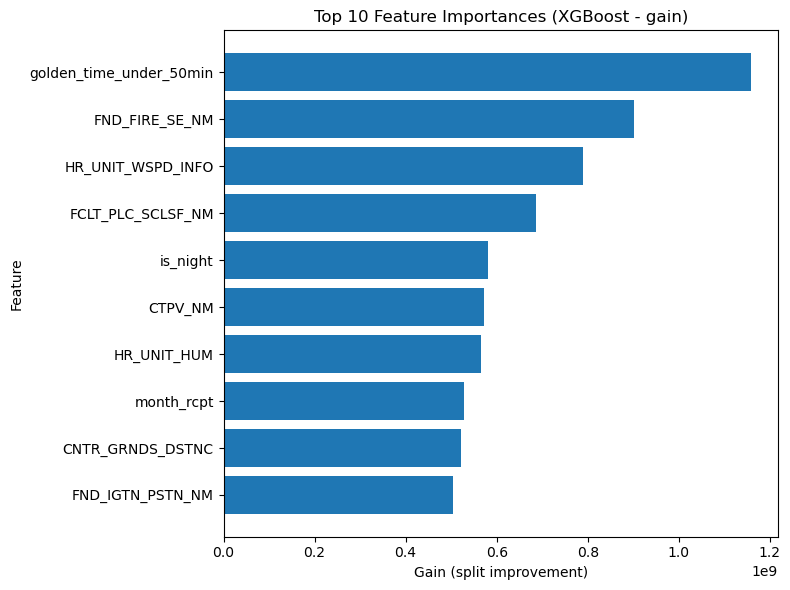

In [8]:
print("\n[STEP4] Feature Importance Top 10 (gain 기준, Train+Val로 재학습, seed=42)")

model_imp = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    **best_params
)
model_imp.fit(X_rem, y_rem)   # 80% (Train+Val)

booster = model_imp.get_booster()
score_dict = booster.get_score(importance_type='gain')  # dict: {feature_name: gain}

# 키가 f0,f1... 형태일 수도 있으므로 안전 매핑
def _map_gain_dict(score_dict, booster, X_cols):
    keys = list(score_dict.keys())
    # f0 패턴 감지
    is_f_pattern = all(k.startswith('f') and k[1:].isdigit() for k in keys) if keys else False
    if is_f_pattern:
        feature_names = booster.feature_names or list(X_cols)
        mapped = {feature_names[int(k[1:])]: v for k, v in score_dict.items()}
    else:
        mapped = score_dict
    # 모든 피처에 대해 값 준비(없으면 0)
    gains = [mapped.get(col, 0.0) for col in X_cols]
    return gains

gains = _map_gain_dict(score_dict, booster, X.columns)
fi_df = pd.DataFrame({"feature": X.columns, "gain": gains}).sort_values("gain", ascending=False)
fi_top10 = fi_df.head(10).reset_index(drop=True)
display(fi_top10)

# 그래프 (Top10만)
plt.figure(figsize=(8, 6))
plt.barh(fi_top10["feature"][::-1], fi_top10["gain"][::-1])
plt.xlabel("Gain (split improvement)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (XGBoost - gain)")
plt.tight_layout()
plt.show()



[STEP5] SHAP Top 10


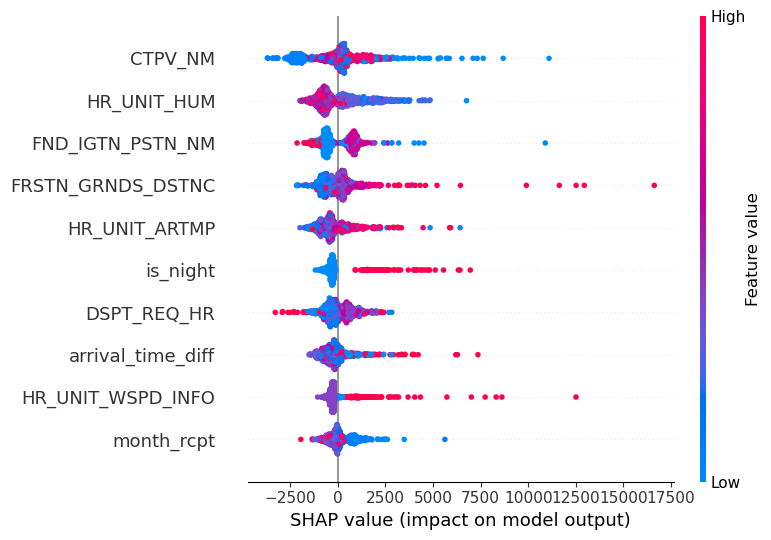

Exception ignored in: <function ResourceTracker.__del__ at 0x104f1dd00>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10343dd00>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1075f5d00>
Traceback (most recent call last

In [12]:
print("\n[STEP5] SHAP Top 10")

import shap
# 연산량 관리: Test에서 최대 2000행만 사용
sample_n = min(2000, len(X_test))
X_sample = X_test.sample(sample_n, random_state=42)

explainer = shap.TreeExplainer(model_imp)
_sv = explainer.shap_values(X_sample)
shap_values = _sv[0] if isinstance(_sv, list) else _sv  # 회귀는 보통 ndarray, 방어 코드

shap.summary_plot(
    shap_values,
    X_sample,
    max_display=10,
    show=True
)
